# 리뷰감정분석


## 라이브러리 임포트


In [1]:
import os
import re
import pickle
import requests
import warnings
from tqdm import tqdm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud

In [3]:
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
# Warning 무시
warnings.filterwarnings('ignore', category=UserWarning)

# Seaborn 테마 설정
sns.set_theme(style='whitegrid')

# matplotlib 한글 폰트 설정
os.system('rm -rf ~/.cache/matplotlib')
os.system('fc-cache -fv')

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

Font directories:
	/System/Library/Assets/com_apple_MobileAsset_Font3
	/System/Library/Assets/com_apple_MobileAsset_Font4
	/System/Library/Fonts
	/Library/Fonts
	/Users/registry/Library/Fonts
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7
	/Users/registry/.local/share/fonts
	/usr/local/share/fonts
	/usr/share/fonts
	/Users/registry/.fonts
	/System/Library/Fonts/Supplemental
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7/0818d874bf1d0e24a1fe62e79f407717792c5ee1.asset
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7/0ab217c39c45c7c6acaddfa199fd32c55a7b4a19.asset
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7/10b097deccb3c6126d986e24b1980031ff7399da.asset
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7/12cc699be28fb04f3e3c4969a0378a87b920b174.asset
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7/157acc4d862730d6d5beaa943546f80a71948c7b.asset
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7/18189590ed3a5f46cef20ed4d1cec2611dca13ff.asset
	/System/L

## 데이터 로드


### TrainSet 내려받기, 저장 및 로드


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB
중복 제거 전 고유 문서 수: 146182
중복 제거 후 데이터 형태: (146183, 3)


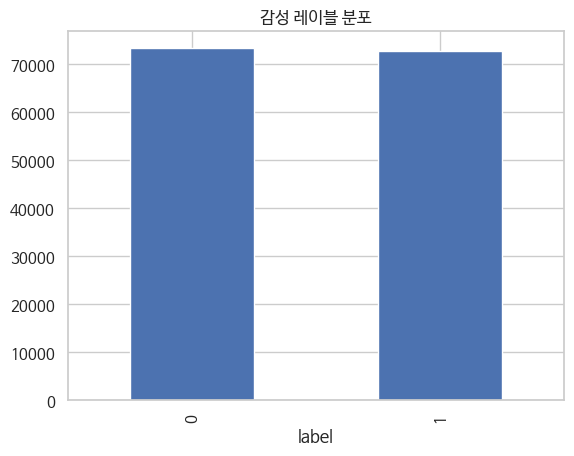

결측치 수: 0
빈 문서 수: 391
최종 데이터 형태: (145791, 3)


100%|██████████| 145791/145791 [04:05<00:00, 594.09it/s]


X_train.pkl 및 y_train.pkl 파일 저장 완료!


In [5]:
response = requests.get("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt")
with open("../data/mining/ratings_train.txt", "wb") as f:
  f.write(response.content)

df_train = pd.read_table("../data/mining/ratings_train.txt")
df_train.info()

# 데이터 전처리
# 1. 중복 제거
print(f"중복 제거 전 고유 문서 수: {df_train['document'].nunique()}")
df_train = df_train.drop_duplicates(subset=['document'])
print(f"중복 제거 후 데이터 형태: {df_train.shape}")

# 2. 레이블 분포 확인
df_train['label'].value_counts().plot(kind='bar')
plt.title('감성 레이블 분포')
plt.show()

# 3. 결측치 제거
df_train = df_train.dropna(how='any')
print(f"결측치 수: {df_train.isnull().values.sum()}")

# 4. 한글과 공백만 남기기
df_train['document'] = df_train['document'].apply(lambda x: re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", x))

# 5. 빈 문자열 처리
empty_docs_count = df_train.loc[df_train['document'] == '', 'document'].count()
print(f"빈 문서 수: {empty_docs_count}")
df_train.replace({'document': {'': np.nan}}, inplace=True)
df_train = df_train.dropna(how='any')
print(f"최종 데이터 형태: {df_train.shape}")

# 형태소 분석
okt = Okt()
X_train = []
y_train = []

# 진행 상황 표시와 함께 형태소 분석 수행
for sentence, label in tqdm(zip(df_train['document'], df_train['label']), total=len(df_train)):
  # 형태소 분리, 정규화, 어간 추출
  morphs = okt.morphs(sentence, stem=True, norm=True)
  X_train.append(morphs)
  y_train.append(label)

# 데이터 저장
with open("../data/mining/X_train.pkl", "wb") as f:
  pickle.dump(X_train, f)

with open("../data/mining/y_train.pkl", "wb") as f:
  pickle.dump(y_train, f)

print("X_train.pkl 및 y_train.pkl 파일 저장 완료!")

In [6]:
# 훈련된 모델 및 TF-IDF 벡터라이저 불러오기
with open("../data/mining/X_train.pkl", "rb") as f:
  X_train = pickle.load(f)

with open("../data/mining/y_train.pkl", "rb") as f:
  y_train = pickle.load(f)

### TestSet 로드


In [7]:
# 테스트 데이터 로드
df_test = pd.read_csv("../data/mining/kakao_map_place_comment.csv", encoding='utf-8-sig')

# 중복 제거
df_test = df_test.drop_duplicates(subset=['contents'])

# 한글과 공백만 남기고 정제
df_test['contents'] = df_test['contents'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True).str.strip()

# 빈 문자열 처리
df_test['contents'] = df_test['contents'].replace('', np.nan)

# 결측치 제거
df_test = df_test.dropna(subset=['contents'])

## 데이터 전처리


In [8]:
# TF-IDF 벡터라이저 로드
tfidf_vectorizer = TfidfVectorizer()
X_train = [' '.join(words) for words in X_train]  # 리스트를 문자열로 변환
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)  # 훈련 데이터 변환

In [9]:
# 형태소 분석기 설정
okt = Okt()

# 형태소 분석 (토큰화 후 문자열로 변환) - 리스트 컴프리헨션 사용
X_test = [' '.join(okt.morphs(sentence, stem=True, norm=True)) for sentence in tqdm(df_test['contents'])]

100%|██████████| 48353/48353 [02:06<00:00, 381.17it/s]


In [10]:
# 로지스틱 회귀 모델 로드
log_reg = LogisticRegression(max_iter=100000).fit(X_train_tfidf, y_train)

In [11]:
# 테스트 데이터 감정 분석 및 라벨 예측
X_test_tfidf = tfidf_vectorizer.transform(X_test)  # TF-IDF 변환
predicted_labels = log_reg.predict(X_test_tfidf)  # 감정 예측

In [12]:
# 예측된 감정 라벨을 데이터프레임에 추가
df_test['label'] = predicted_labels

In [13]:
# 결과 확인 및 CSV 저장
print(df_test[['contents', 'label']].head(10))  # 상위 5개 데이터 확인
df_test.to_csv("../data/mining/labeled_test_data.csv", encoding='utf-8-sig', index=False)  # 결과 저장

                                            contents  label
0  와 대박 먹을대 없어서 아무 기대없이 들어같는대 진짜 완전 맛있어요사진 찍을 생각도...      1
1                                                마이쪙      0
2             가성비 좋음세트메뉴도 구성 좋음간짜장을 생각보다 자주 먹으러 가게 됨      1
3  가지마셈 ㅋㅋㅋ  프렌차이츠에서 프렌차이즈 메뉴가 안되는건 또 처음보네 ㅋㅋㅋㅋㅋ ...      0
4  콜라 리필 안됨감튀 식어있음냅킨 누구 주기도 부끄러울 만큼 줌이벤트 한다 써놓고 막...      0
5               친절하고 다 좋긴한데 여러번 먹어본 결과 소스 포함해서 양이 적음      1
6  바로바로 조리맘터 원칙이지만 식어있는 감튀 주는 곳도 봄푸짐한 속 재료가끔 너겟도 ...      0
7  여태 이런 맛집을 곁에 두고 몰랐다는 사실에 충격 받았습니다 진짜 제육은 가성비는 ...      1
8                                                개맛집      1
9                                               밥 맛집      1


In [14]:
# 지역별 카테고리 설정
yg_regions = [
    '대학로', '북촌', '서촌', '홍대입구역', '합정', '연남',
    '해방촌', '경리단길', '종로3가', '성수동', '신사동 가로수길',
    '송리단길', '명동', '신림', '문래', '이수역', '용리단길'
]
ng_regions = [
    '강남역', '압구정로데오', '건대입구역', '여의도역',
    '동대문', '잠실역', '회기역', '영등포', '청담', '사당'
]
nm_regions = [
    '성내동', '시흥동', '삼양동', '중화동', '월계동',
    '응암동', '신도림동', '신정동', '도봉동', '방화동'
]

# 지역을 기반으로 카테고리 분류
def categorize_region(region):
  match region:
    case _ if region in yg_regions:
      return '젠트리피케이션'
    case _ if region in ng_regions:
      return '비젠트리피케이션'
    case _ if region in nm_regions:
      return '기본상권지'
    case _:
      return '기타'

# df_test에 지역별 카테고리 추가
df_test['category'] = df_test['region'].apply(categorize_region)

# '기타' 지역 제외
df_test = df_test[df_test['category'] != '기타']

In [15]:
df_test.head()

,commentid,contents,point,username,profile,profileStatus,photoCnt,likeCnt,thumbnail,kakaoMapUserId,...,level,date,isMy,isBlock,isEditable,isMyLike,region,booking,label,category
0,11548111,와 대박 먹을대 없어서 아무 기대없이 들어같는대 진짜 완전 맛있어요사진 찍을 생각도...,5,kallismar,http://k.kakaocdn.net/dn/kQ21M/btqwExAC1CO/fWC...,S,1,1,http://t1.daumcdn.net/local/kakaomapPhoto/revi...,1122874090,...,"{'nowLevel': 32, 'badge': '03'}",2024.12.02.,False,False,False,False,대학로,NaN,1,젠트리피케이션
1,9102935,마이쪙,5,김민석,http://k.kakaocdn.net/dn/luL8e/btrgdFU6i8p/Wbt...,S,0,0,NaN,1929390282,...,"{'nowLevel': 2, 'badge': '01'}",2023.12.08.,False,False,False,False,대학로,NaN,0,젠트리피케이션
2,6983114,가성비 좋음세트메뉴도 구성 좋음간짜장을 생각보다 자주 먹으러 가게 됨,4,quaso,http://t1.daumcdn.net/local/kakaomapPhoto/prof...,S,0,0,NaN,1150558037,...,"{'nowLevel': 23, 'badge': '02'}",2023.08.10.,False,False,False,False,대학로,NaN,1,젠트리피케이션
3,7793189,가지마셈 ㅋㅋㅋ 프렌차이츠에서 프렌차이즈 메뉴가 안되는건 또 처음보네 ㅋㅋㅋㅋㅋ ...,1,쭈넵,http://t1.daumcdn.net/local/kakaomapPhoto/prof...,S,0,0,NaN,756168138,...,"{'nowLevel': 5, 'badge': '01'}",2023.06.04.,False,False,False,False,대학로,NaN,0,젠트리피케이션
4,6983091,콜라 리필 안됨감튀 식어있음냅킨 누구 주기도 부끄러울 만큼 줌이벤트 한다 써놓고 막...,1,quaso,http://t1.daumcdn.net/local/kakaomapPhoto/prof...,S,0,0,NaN,1150558037,...,"{'nowLevel': 23, 'badge': '02'}",2023.03.03.,False,False,False,False,대학로,NaN,0,젠트리피케이션


In [16]:
df_price_gen = df_test[df_test['category'] == '젠트리피케이션'][['contents', 'label']]
df_price_gen[df_price_gen['contents'].str.contains('가격', na=False)]['label'].value_counts()

label
0    1091
1     894
Name: count, dtype: int64

In [17]:
df_price_gen[df_price_gen['contents'].str.contains('가격', na=False)].head(30)

,contents,label
31,부추전 김치찜 먹는데 맛있긴 함다만 가격대 있고 테이블 간격 좁아서 엄청 시끄러워 ...,0
55,보쌈 먹었는데 이 돈 주고 이거 먹으려고 왔나 생각만 들었다 너무 어이없는 양과 가...,0
57,이렇게 불친절할수가그럼에도 음식이라도 맛있으면 다 커버될텐데 음식도 따듯하지도 않고...,0
101,맛없진 않는데 가격대비그닥다그닥걍 다른데 가세요,0
102,리뷰 잘 안남기는데 너무 기분나쁘고 별로였어서 남깁니다김치찜을 시켰을 때 김치찜에 ...,0
106,보쌈 소와 매운돼지갈비찜 시켰어요보쌈은 너무 뻑뻑해서 남겼고 가격대비 양도 많이 적...,1
110,음식이 전체적으로 다짜고주문전에 양을 잘몰라 두명이서 메인메뉴 두개시키면 많을까하여...,0
122,가격은 착한편임 수육은 먹을만함 김치찜은 좀 단맛이 강함 파전은 특이하게 대파를 써...,0
166,맛은 그럭저럭 평범한데 양에 비해 가격이 시켜보시면 이해 되실겁니다,0
222,간도 딱 좋고 순두부 정말 부드러워서 좋았어요 해물순두부에 해물이 어마어마하게 들어...,1


In [18]:
df_price_nongen = df_test[df_test['category'] == '비젠트리피케이션'][['contents', 'label']]
df_price_nongen[df_price_nongen['contents'].str.contains('가격', na=False)]['label'].value_counts()

label
0    666
1    467
Name: count, dtype: int64

In [19]:
df_price_basic = df_test[df_test['category'] == '기본상권지'][['contents', 'label']]
df_price_basic[df_price_basic['contents'].str.contains('가격', na=False)]['label'].value_counts()

label
0    337
1    287
Name: count, dtype: int64

## 모델링 및 분석


### 카테고리별 긍/부정 비율 비교


---
- 젠트리 지역이 비젠트리 지역보다 부정적인 리뷰가 적고, 긍정적인 리뷰가 많음.
- 비젠트리 지역에서 부정적인 리뷰가 더 많아 상권 만족도가 상대적으로 낮을 가능성이 있음.
- 기본상권지는 두 지역 사이의 중간값을 가지며, 무난한 평점 분포를 보임.
---

이런식으로 해석하면 어떨까 싶어요!

비젠트리피케이션 지역은 젠트리피케이션 지역보다 상대적으로 유명하지 않아서, 방문객들이 기대하는 서비스 품질과 실제 경험이 차이가 날 가능성이 있음.

즉, 유명한 젠트리피케이션 지역에서는 "평균적인 경험도 긍정적으로 평가"하는 반면, 비젠트리피케이션 지역에서는 "좋은 경험이 아니면 부정적으로 평가"할 확률이 높음.

비젠트리피케이션 지역은 지역 주민이 주 고객층일 가능성이 높음 -> 반복 방문을 하면서 실망하는 요소(가격 상승, 서비스 변화 등)를 경험할 가능성이 큼.

반면, 젠트리피케이션 지역은 관광객, 일회성 방문이 많아 "첫인상"이 좋으면 긍정적 리뷰를 남기는 경우가 많을 수 있음.


In [20]:
# 각 카테고리별 긍/부정 리뷰 개수 집계
sentiment_counts = df_test.groupby(['category', 'label']).size().unstack()
sentiment_counts

label,0,1
category,,
기본상권지,3266,4599
비젠트리피케이션,5808,7045
젠트리피케이션,10791,16492


In [21]:
# 각 감정별 비율로 변환 (각 그룹 내 백분율)
sentiment_ratio = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100
sentiment_ratio

label,0,1
category,,
기본상권지,41.525747,58.474253
비젠트리피케이션,45.187894,54.812106
젠트리피케이션,39.552102,60.447898


<Figure size 1000x600 with 0 Axes>

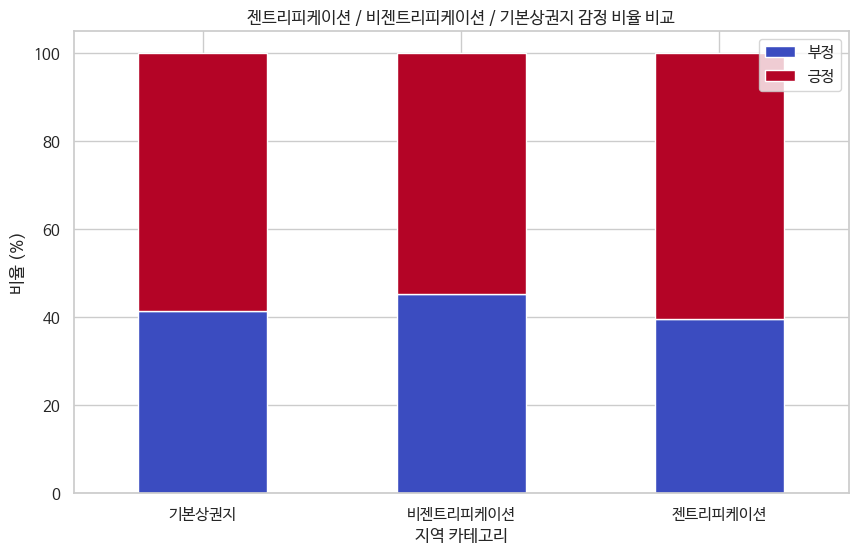

In [22]:
# 시각화
plt.figure(figsize=(10, 6))
sentiment_ratio.plot(kind='bar', stacked=True, colormap="coolwarm", figsize=(10, 6))
plt.title("젠트리피케이션 / 비젠트리피케이션 / 기본상권지 감정 비율 비교")
plt.xlabel("지역 카테고리")
plt.ylabel("비율 (%)")
plt.xticks(rotation=0)
plt.legend(["부정", "긍정"])
plt.show()

In [23]:
# 1~5점별 긍정(1) / 부정(0) 개수 집계
point_sentiment_counts = df_test.groupby(['point', 'label']).size().unstack(fill_value=0)

# 1~5점별 긍/부정 비율 계산
point_sentiment_ratio = point_sentiment_counts.div(point_sentiment_counts.sum(axis=1), axis=0) * 100
point_sentiment_ratio

label,0,1
point,,
1,86.826120,13.173880
2,75.448718,24.551282
3,53.859680,46.140320
4,32.260213,67.739787
5,21.006103,78.993897


### 평점별 감정 비율


평점이 높을수록 긍정적인 감정이 증가하고, 평점이 낮을수록 부정적인 감정이 증가하는 경향을 확인할 수 있음.

감정 분석 라벨링이 적절하게 이루어졌음을 검증함


<Figure size 800x500 with 0 Axes>

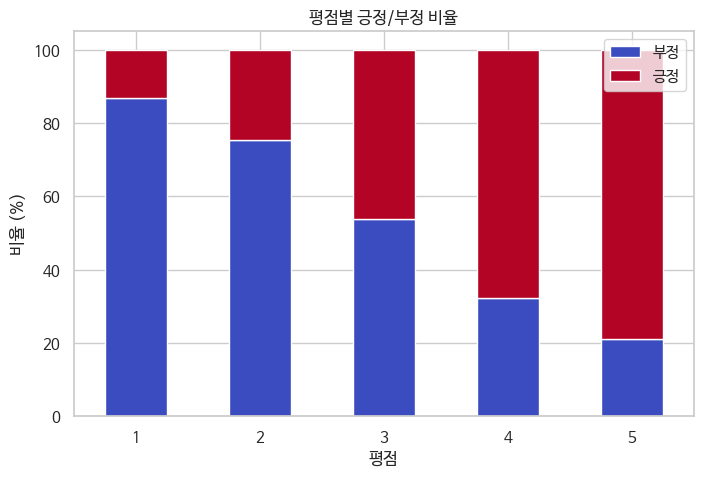

In [24]:
# 시각화
plt.figure(figsize=(8, 5))
point_sentiment_ratio.plot(kind='bar', stacked=True, colormap="coolwarm", figsize=(8, 5))
plt.title("평점별 긍정/부정 비율")
plt.xlabel("평점")
plt.ylabel("비율 (%)")
plt.xticks(rotation=0)
plt.legend(["부정", "긍정"])  # 0: 부정, 1: 긍정
plt.show()

### 평점(1~5)별 젠트리피케이션 / 비젠트리피케이션 / 기본상권지에 대한 긍정/부정 비율 비교


젠트리 지역이 상대적으로 긍정적인 리뷰 비율이 더 높은 경향을 보임.

상권 특성 차이로 해석될 수 있음.


In [25]:
all_points = [1, 2, 3, 4, 5]
all_categories = ["젠트리피케이션", "비젠트리피케이션", "기본상권지"]

# 모든 조합을 포함하도록 데이터 재구성
multi_index = pd.MultiIndex.from_product([all_categories, all_points], names=['category', 'point'])
sentiment_counts = df_test.groupby(['category', 'point', 'label']).size().unstack(fill_value=0).reindex(multi_index, fill_value=0)

# 비율 계산
sentiment_ratio = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100
sentiment_ratio

label                   0          1
category point                      
젠트리피케이션  1      86.483954  13.516046
         2      74.883991  25.116009
         3      52.053973  47.946027
         4      30.818080  69.181920
         5      19.220697  80.779303
비젠트리피케이션 1      86.720067  13.279933
         2      75.641026  24.358974
         3      56.153370  43.846630
         4      34.137214  65.862786
         5      23.791418  76.208582
기본상권지    1      88.183981  11.816019
         2      77.173913  22.826087
         3      57.006803  42.993197
         4      34.827862  65.172138
         5      22.716346  77.283654

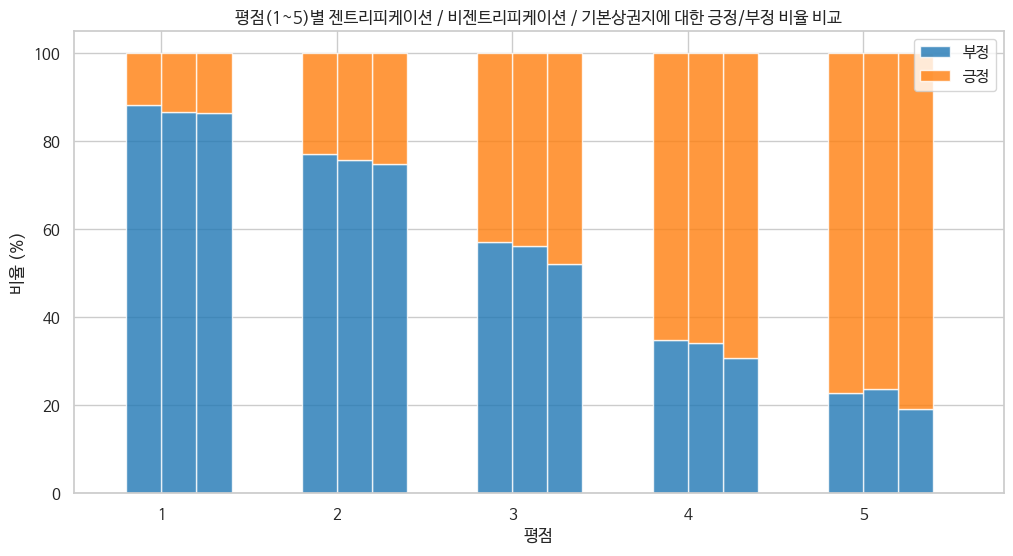

In [26]:
# X축의 위치 조정
points = sorted(sentiment_ratio.index.get_level_values('point').unique())  # 평점(1~5)
x = np.arange(len(points))
width = 0.2

# 그래프 설정
fig, ax = plt.subplots(figsize=(12, 6))
colors = ["#1f77b4", "#ff7f0e"]

# 같은 평점 내에서 지역별로 나란히 배치
for idx, category in enumerate(["젠트리피케이션", "비젠트리피케이션", "기본상권지"]):
  category_data = sentiment_ratio.xs(category, level='category')

  category_data = category_data.reindex(points, fill_value=0)

  # 각 평점에서 3개의 카테고리가 보이도록 설정
  category_data.plot(
      kind='bar', stacked=True, color=colors, alpha=0.8, width=width, position=idx - 1, ax=ax, label=category
  )

# X축을 평점(1~5)로 설정
ax.set_xticks(x)
ax.set_xticklabels(points, rotation=0)
ax.set_xlim(-0.5, len(points) - 0.2)

plt.title("평점(1~5)별 젠트리피케이션 / 비젠트리피케이션 / 기본상권지에 대한 긍정/부정 비율 비교")
plt.xlabel("평점")
plt.ylabel("비율 (%)")
plt.legend(["부정", "긍정"])
plt.show()

### 각 지역별로 각각 토픽 모델링을 해서 자주 나오는 단어를 알아본다면???


In [27]:
df_yg = df_test[df_test['category'] == '젠트리피케이션']
df_ng = df_test[df_test['category'] == '비젠트리피케이션']
df_nm = df_test[df_test['category'] == '기본상권지']

In [28]:
df_yg.to_csv("../data/mining/yg_reviews.csv", encoding='utf-8-sig', index=False)
df_ng.to_csv("../data/mining/ng_reviews.csv", encoding='utf-8-sig', index=False)
df_nm.to_csv("../data/mining/nm_reviews.csv", encoding='utf-8-sig', index=False)

In [29]:
# 형태소 분석기
okt = Okt()

# 텍스트 전처리 함수
def preprocess_text(text):
  text = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", text)  # 한글과 공백만 남김
  tokens = okt.nouns(text)  # 명사만 추출
  return " ".join(tokens)

In [30]:
# 리뷰 텍스트 전처리
for df in [df_yg, df_ng, df_nm]:
  df['processed'] = df['contents'].astype(str).apply(preprocess_text)

/var/folders/9g/4cgtm0f95kv9wyqr9wm_63xc0000gn/T/ipykernel_34385/3488227981.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed'] = df['contents'].astype(str).apply(preprocess_text)
/var/folders/9g/4cgtm0f95kv9wyqr9wm_63xc0000gn/T/ipykernel_34385/3488227981.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed'] = df['contents'].astype(str).apply(preprocess_text)
/var/folders/9g/4cgtm0f95kv9wyqr9wm_63xc0000gn/T/ipykernel_34385/3488227981.py:3: SettingWithCopyWarning: 
A value is tr

In [31]:
# 단어 빈도 벡터화 (CountVectorizer 사용)
def vectorize_text(df, max_features=3000):
  vectorizer = CountVectorizer(max_features=max_features)
  vectors = vectorizer.fit_transform(df['processed'])
  return vectors, vectorizer

# 각 데이터프레임에 대해 벡터화 적용
X, vectorizer_yg = vectorize_text(df_yg)
Y, vectorizer_ng = vectorize_text(df_ng)
Z, vectorizer_nm = vectorize_text(df_nm)

In [32]:
# 단어 빈도 데이터프레임 생성 함수
def create_word_counts_df(vectors, feature_names):
  word_counts = pd.DataFrame({
      'word': feature_names,
      'count': vectors.toarray().sum(axis=0)
  })
  return word_counts.sort_values(by='count', ascending=False)

# 각 벡터화 결과에 대한 단어 빈도 데이터프레임 생성
# X는 df_yg, Y는 df_ng, Z는 df_nm에 대한 벡터화 결과
word_counts_yg = create_word_counts_df(X, vectorizer_yg.get_feature_names_out())
word_counts_ng = create_word_counts_df(Y, vectorizer_ng.get_feature_names_out())
word_counts_nm = create_word_counts_df(Z, vectorizer_nm.get_feature_names_out())

In [33]:
# 상위 30개 단어 출력
display(word_counts_yg.head(10))
display(word_counts_ng.head(10))
display(word_counts_nm.head(10))

,word,count
2602,커피,2495
2406,직원,2485
1219,분위기,2459
2419,진짜,2371
1077,방문,2268
1,가격,2199
1303,사람,1854
864,맛집,1737
2273,정말,1635
2019,음식,1624


,word,count
1,가격,1264
2405,직원,1173
1294,사람,1172
2420,진짜,992
1087,방문,985
1218,분위기,843
2246,정도,832
300,그냥,810
845,맛집,790
2001,음식,775


,word,count
2409,직원,734
172,고기,725
2423,진짜,705
2,가격,699
1058,방문,600
1309,사장,576
850,맛집,573
2258,정말,526
1291,사람,523
2615,커피,504


### 젠트리 / 비젠트리 워드 클라우드


| 비교 항목          | 젠트리피케이션           | 비젠트리피케이션              |
| ------------------ | ------------------------ | ----------------------------- |
| **주요 평가 요소** | 맛, 분위기, 웨이팅, 가격 | 맛, 서비스(불친절), 매장 환경 |
| **특징적인 단어**  | 웨이팅, 자리, 추천, 카페 | 매장, 주문, 불친절, 최고      |
| **긍정적인 요소**  | 분위기, 추천, 카페 감성  | 최고, 분위기                  |
| **부정적인 요소**  | 가격 (비싸다는 의미가틈) | 불친절, 서비스 관련 불만      |

- 젠트리 지역은 분위기/웨이팅/가격에 대한 언급이 많아, 트렌디하고 인기 있는 지역 특성이 반영됨
- 비젠트리 지역은 맛과 서비스(불친절)에 대한 언급이 많아, 상대적으로 운영 방식이나 친절도가 중요한 평가 요소일 가능성이 있음


In [34]:
# 워드 클라우드 생성
wc = WordCloud(
    font_path="NanumBarunGothic",
    background_color="white",
    width=800,
    height=800,
    max_words=200
)

In [35]:
# 모든 리뷰를 하나의 문자열로 합치기
all_reviews_text_yg = " ".join(df_yg['processed'])
all_reviews_text_ng = " ".join(df_ng['processed'])
all_reviews_text_nm = " ".join(df_nm['processed'])

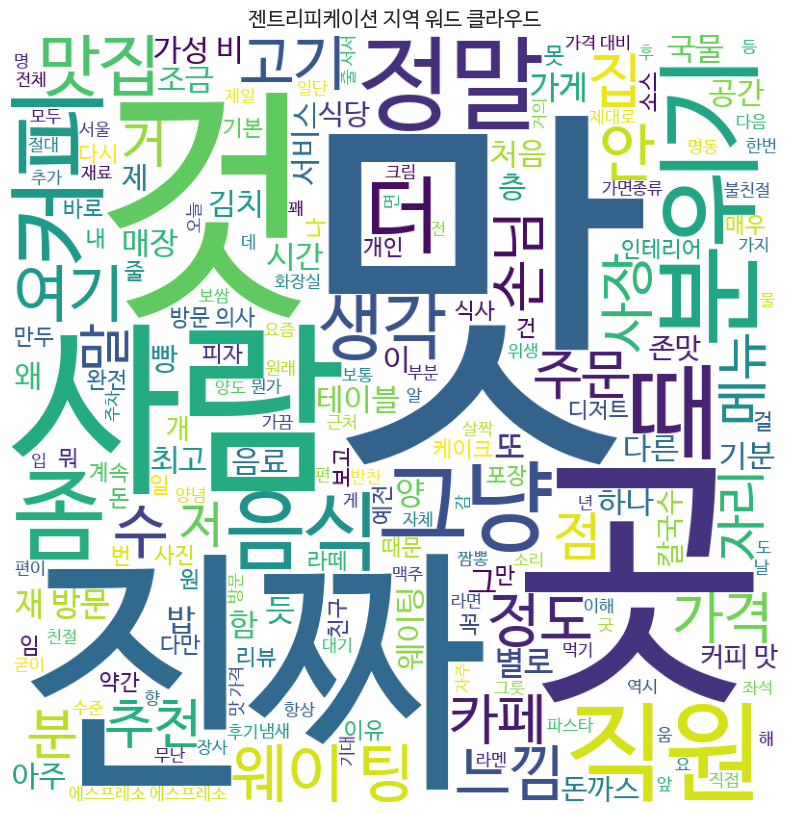

In [36]:
wordcloud = wc.generate(all_reviews_text_yg)

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("젠트리피케이션 지역 워드 클라우드", fontsize=15)
plt.show()

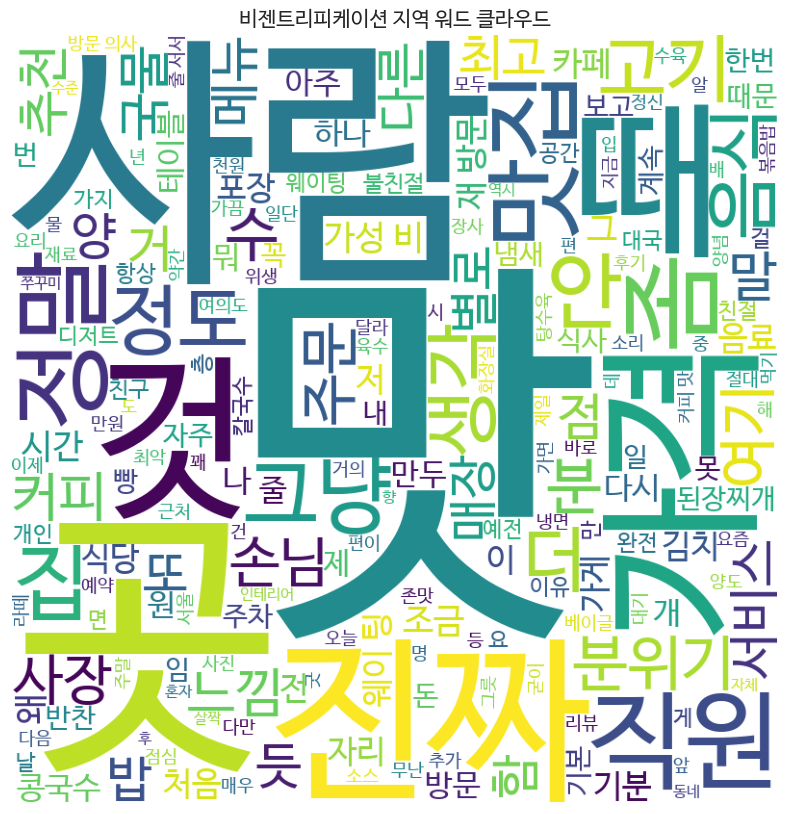

In [37]:
wordcloud = wc.generate(all_reviews_text_ng)

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("비젠트리피케이션 지역 워드 클라우드", fontsize=15)
plt.show()

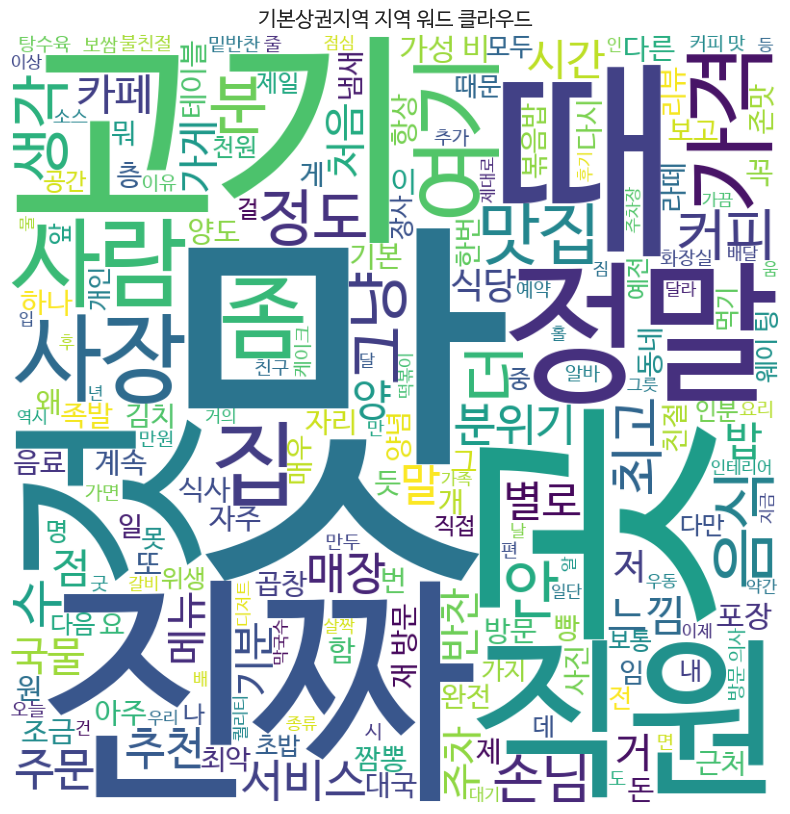

In [38]:
wordcloud = wc.generate(all_reviews_text_nm)

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("기본상권지역 지역 워드 클라우드", fontsize=15)
plt.show()